# Visualization & Comparison Notebook
## PINNs vs Linear Fourier Models — Poisson and Fisher–KPP/Logistic

This notebook compares:
- PDEs: **Poisson** (analytic reference) and **Fisher/Logistic stationary** (tutor-generated dataset)
- Models: **MLP PINN** vs **Linear Fourier (positive frequencies)**
- Objectives: **Residual loss** vs **Energy (variational) loss**
- Loss variants: **with/without regularization**, **with/without data fitting term**

We visualize:
- Loss curves (total + components)
- Predicted solution surfaces / contours
- Error maps vs reference
- Validation metrics tables


In [2]:
import sys
from pathlib import Path

import torch
import matplotlib.pyplot as plt

# Start from the current working directory (where the notebook kernel runs)
cwd = Path.cwd().resolve()

# Find repo root by walking up until we find a "src" folder
ROOT = cwd
while not (ROOT / "src").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent

SRC = ROOT / "src"
sys.path.insert(0, str(SRC))

print("CWD      :", cwd)
print("Repo root:", ROOT)
print("SRC path :", SRC)


from data_loader import load_torch_dataset, train_val_split
from sampling import sample_uniform_interior, sample_uniform_boundary
from equations import PoissonEquation, FisherKPPStationaryEquation
from models import MLPModel, LinearFourierModel
from solvers import train, evaluate_model
from metrics import summarize_errors


CWD      : /workspaces/EA_Physics-Informed_Learning_for_Reaction_Diffusion_Equations/notebooks
Repo root: /workspaces/EA_Physics-Informed_Learning_for_Reaction_Diffusion_Equations
SRC path : /workspaces/EA_Physics-Informed_Learning_for_Reaction_Diffusion_Equations/src


## Global configuration

We define:
- device / dtype
- common plotting utilities
- helpers to run one experiment and collect results consistently


In [3]:
torch.manual_seed(0)

device = torch.device("cpu")
dtype = torch.float32

def make_grid_2d(n=80, low=0.0, high=1.0, device=device, dtype=dtype):
    xs = torch.linspace(low, high, n, device=device, dtype=dtype)
    X, Y = torch.meshgrid(xs, xs, indexing="ij")
    grid = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)
    return xs, grid

def plot_history(history, title="Training history"):
    keys = ["loss_total", "loss_pde", "loss_bc", "loss_data", "loss_reg"]
    plt.figure()
    for k in keys:
        if k in history and len(history[k]) > 0:
            plt.plot(history[k], label=k)
    plt.yscale("log")
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_surface(xs, u_grid, title="u(x,y) surface"):
    # u_grid: (n*n, 1)
    n = xs.numel()
    U = u_grid.reshape(n, n).detach().cpu()
    X, Y = torch.meshgrid(xs.cpu(), xs.cpu(), indexing="ij")
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(projection="3d")
    ax.plot_surface(X.numpy(), Y.numpy(), U.numpy())
    ax.set_title(title)
    plt.show()

def plot_contour(xs, u_grid, title="u(x,y) contour"):
    n = xs.numel()
    U = u_grid.reshape(n, n).detach().cpu()
    X, Y = torch.meshgrid(xs.cpu(), xs.cpu(), indexing="ij")
    plt.figure(figsize=(6,5))
    plt.contourf(X.numpy(), Y.numpy(), U.numpy(), levels=40)
    plt.colorbar()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

def plot_error(xs, u_pred, u_true, title="|error|"):
    err = (u_pred - u_true).abs()
    plot_contour(xs, err, title=title)

def print_metrics(u_pred, u_true, title="Metrics"):
    m = summarize_errors(u_pred, u_true)
    print(f"\n=== {title} ===")
    for k,v in m.items():
        print(f"{k:>10s}: {v:.6e}")
    return m


## Unified experiment runner

We create a helper to run a single training configuration:
- equation object
- model (MLP vs Fourier)
- loss mode (residual vs energy)
- weights (PDE / BC / data / reg)
- collocation points
- returns history + predictions on a grid + metrics


In [4]:
def run_experiment(
    *,
    name: str,
    equation,
    model,
    x_interior,
    x_boundary=None,
    u_boundary=None,
    # supervised term:
    x_data=None,
    u_data=None,
    # loss selection:
    use_energy: bool = False,
    # weights:
    w_pde: float = 1.0,
    w_bc: float = 0.0,
    w_data: float = 0.0,
    w_reg: float = 0.0,
    # optimizer:
    lr: float = 1e-3,
    steps: int = 2000,
    print_every: int = 200,
    # evaluation grid:
    grid_n: int = 80,
    grid_low: float = 0.0,
    grid_high: float = 1.0,
    u_true_fn=None,      # callable for analytic reference on grid
    u_true_data=None,    # tensor reference (val set)
):
    # NOTE: assumes your train() already supports data/reg weights if you added them.
    # If not, it will still run with PDE/BC only.
    history = train(
        model,
        equation,
        x_interior,
        x_boundary=x_boundary,
        u_boundary=u_boundary,
        x_data=x_data,
        u_data=u_data,
        use_energy=use_energy,
        w_pde=w_pde,
        w_bc=w_bc,
        w_data=w_data,
        w_reg=w_reg,
        lr=lr,
        steps=steps,
        print_every=print_every,
    )

    xs, grid = make_grid_2d(n=grid_n, low=grid_low, high=grid_high)
    with torch.no_grad():
        u_pred_grid = model(grid).detach()

    out = {"name": name, "history": history, "xs": xs, "grid": grid, "u_pred_grid": u_pred_grid}

    if u_true_fn is not None:
        with torch.no_grad():
            u_true_grid = u_true_fn(grid).detach()
        out["u_true_grid"] = u_true_grid
        out["metrics_grid"] = summarize_errors(u_pred_grid, u_true_grid)

    if (u_true_data is not None) and (x_data is not None):
        with torch.no_grad():
            u_pred_data = model(x_data).detach()
        out["metrics_data"] = summarize_errors(u_pred_data, u_true_data)

    return out


# Part A — Poisson equation (analytic reference)

We use a known solution on the unit square:
- Domain: [0,1]^2
- Exact solution: u(x,y) = x^2 + y^2
- Laplacian: Δu = 4
For Poisson in the form: -Δu = f, we set f = -4.

We use Dirichlet boundary values from the exact solution.


In [5]:
def u_poisson_exact(x):
    X = x[:, 0:1]
    Y = x[:, 1:2]
    return X**2 + Y**2

f_poisson = lambda x: -4.0 * torch.ones(x.shape[0], 1, device=x.device, dtype=x.dtype)
eq_poisson = PoissonEquation(f=f_poisson)

# Collocation points
n_in, n_b = 6000, 1200
x_in = sample_uniform_interior(n_in, 2, device=device, dtype=dtype)
x_b  = sample_uniform_boundary(n_b, 2, device=device, dtype=dtype)

# Dirichlet BC from exact solution
u_b = u_poisson_exact(x_b).detach()

print(x_in.shape, x_b.shape, u_b.shape)


torch.Size([6000, 2]) torch.Size([1200, 2]) torch.Size([1200, 1])


## Poisson experiments

We run:
1) MLP + residual loss
2) MLP + energy loss
3) Fourier + residual loss
4) Fourier + energy loss

We also demonstrate "with regularization" vs "no regularization" by toggling `w_reg`.


In [6]:
def print_run_config(
    name: str,
    model,
    equation_name: str,
    *,
    use_energy: bool,
    w_pde: float,
    w_bc: float,
    w_data: float,
    w_reg: float,
    lr: float,
    steps: int,
    n_interior: int,
    n_boundary: int,
    grid_n: int,
    domain: str = "[0,1]^2",
):
    n_params = sum(p.numel() for p in model.parameters())
    print("\n" + "=" * 80)
    print(f"RUN: {name}")
    print("-" * 80)
    print(f"Equation       : {equation_name}")
    print(f"Domain         : {domain}")
    print(f"Model class    : {model.__class__.__name__}")
    print(f"# parameters   : {n_params:,}")
    print(f"Objective      : {'energy (variational)' if use_energy else 'residual (PINN)'}")
    print(f"Weights        : w_pde={w_pde}, w_bc={w_bc}, w_data={w_data}, w_reg={w_reg}")
    print(f"Optimizer      : Adam(lr={lr})")
    print(f"Steps          : {steps}")
    print(f"Collocation    : interior={n_interior}, boundary={n_boundary}")
    print(f"Eval grid      : {grid_n}x{grid_n}")
    print("=" * 80)


In [7]:
poisson_results = []

def make_mlp():
    return MLPModel(input_dim=2, hidden_dim=64, num_hidden_layers=4, activation="tanh").to(device)

def make_fourier():
    return LinearFourierModel(input_dim=2, max_freq=8).to(device)

configs = [
    ("MLP residual no-reg",  make_mlp,   False, 0.0),
    ("MLP energy   no-reg",  make_mlp,   True,  0.0),
    ("Fourier residual no-reg", make_fourier, False, 0.0),
    ("Fourier energy   no-reg", make_fourier, True,  0.0),
    ("MLP residual reg",     make_mlp,   False, 1e-6),
    ("Fourier residual reg", make_fourier, False, 1e-6),
]


w_pde = 1.0
w_bc = 10.0
w_data = 0.0
lr = 1e-3
steps = 2000
print_every = 400
grid_n = 90

for name, model_fn, use_energy, w_reg in configs:
    model = model_fn()

    print_run_config(
        name=name,
        model=model,
        equation_name="Poisson",
        use_energy=use_energy,
        w_pde=w_pde,
        w_bc=w_bc,
        w_data=w_data,
        w_reg=w_reg,
        lr=lr,
        steps=steps,
        n_interior=x_in.shape[0],
        n_boundary=x_b.shape[0],
        grid_n=grid_n,
        domain="[0,1]^2",
    )

    
    res = run_experiment(
        name=name,
        equation=eq_poisson,
        model=model,
        x_interior=x_in,
        x_boundary=x_b,
        u_boundary=u_b,
        use_energy=use_energy,
        w_pde=w_pde,
        w_bc=w_bc,
        w_data=w_data,
        w_reg=w_reg,
        lr=lr,
        steps=steps,
        print_every=print_every,
        grid_n=grid_n,
        grid_low=0.0,
        grid_high=1.0,
        u_true_fn=u_poisson_exact,
    )
    poisson_results.append(res)

print("Done. Number of runs:", len(poisson_results))



RUN: MLP residual no-reg
--------------------------------------------------------------------------------
Equation       : Poisson
Domain         : [0,1]^2
Model class    : MLPModel
# parameters   : 12,737
Objective      : residual (PINN)
Weights        : w_pde=1.0, w_bc=10.0, w_data=0.0, w_reg=0.0
Optimizer      : Adam(lr=0.001)
Steps          : 2000
Collocation    : interior=6000, boundary=1200
Eval grid      : 90x90
[step     1] total=2.582008e+01 pde=1.601312e+01 bc=9.806960e-01 data=0.000000e+00 reg=0.000000e+00
[step   400] total=4.473054e-02 pde=3.363736e-02 bc=1.109318e-03 data=0.000000e+00 reg=0.000000e+00
[step   800] total=1.711437e-02 pde=1.578544e-02 bc=1.328929e-04 data=0.000000e+00 reg=0.000000e+00
[step  1200] total=4.766335e-03 pde=4.485240e-03 bc=2.810950e-05 data=0.000000e+00 reg=0.000000e+00
[step  1600] total=1.060997e-03 pde=1.034273e-03 bc=2.672367e-06 data=0.000000e+00 reg=0.000000e+00
[step  2000] total=8.450249e-04 pde=8.278809e-04 bc=1.714408e-06 data=0.0000

## Poisson: loss curves

We visualize the total loss and its components for each configuration.

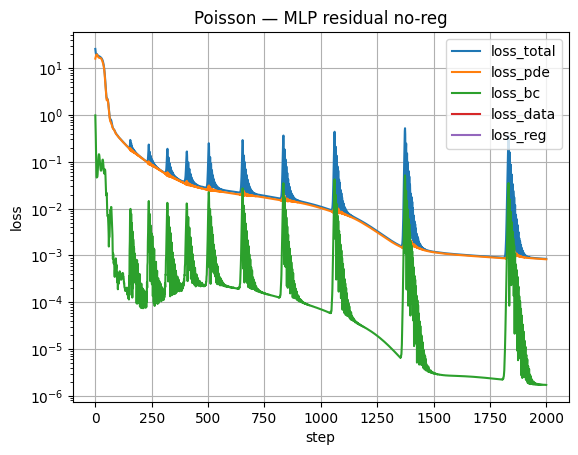

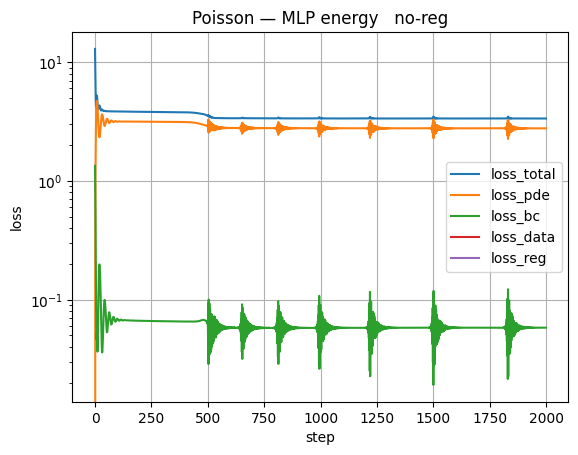

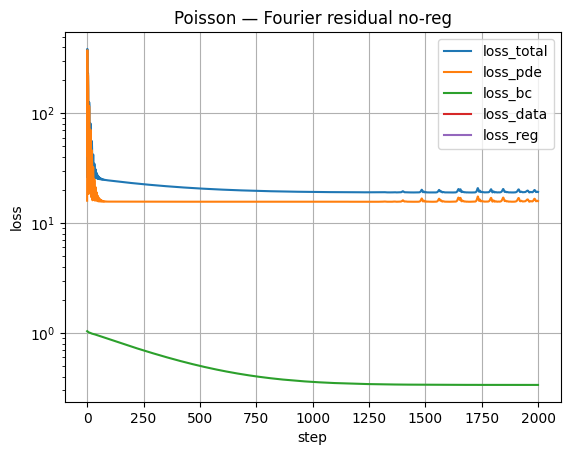

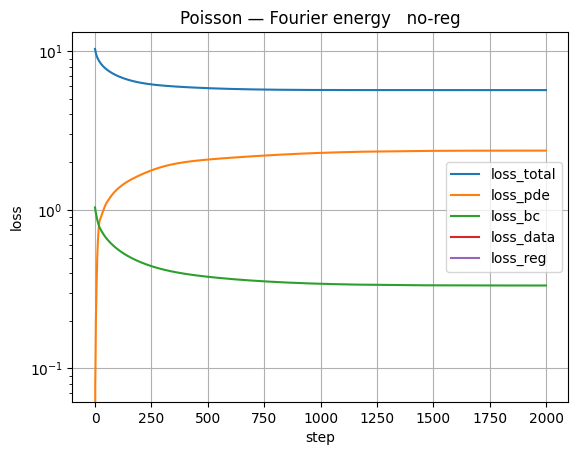

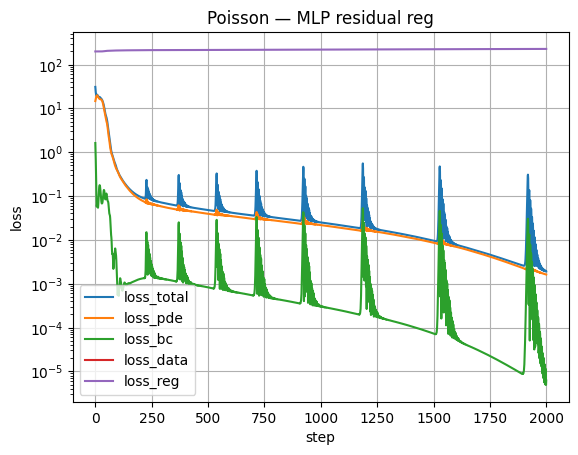

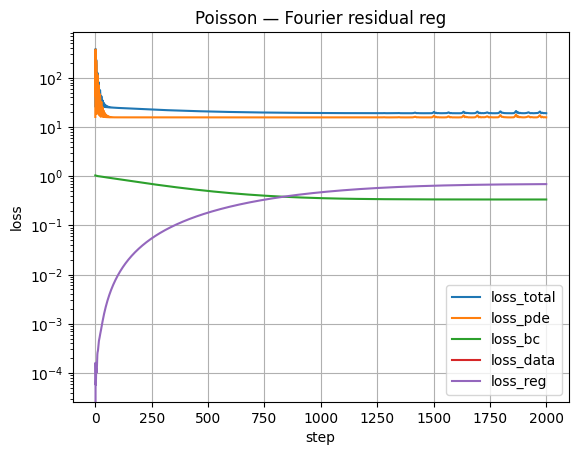

In [8]:
for r in poisson_results:
    plot_history(r["history"], title=f"Poisson — {r['name']}")

## Poisson: predicted solution vs exact solution

We plot:
- predicted u(x,y)
- exact u(x,y)
- absolute error map


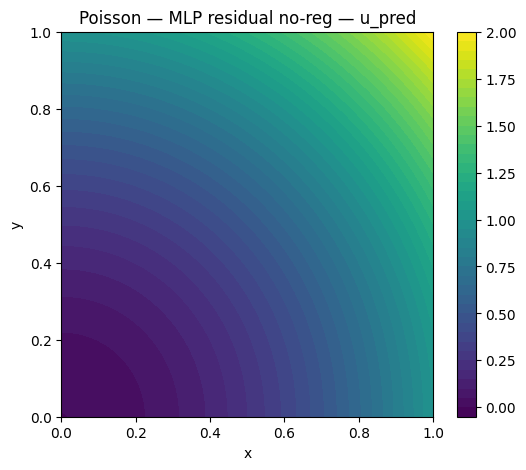

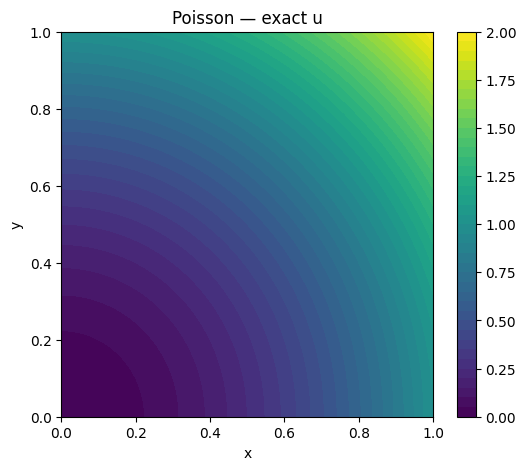

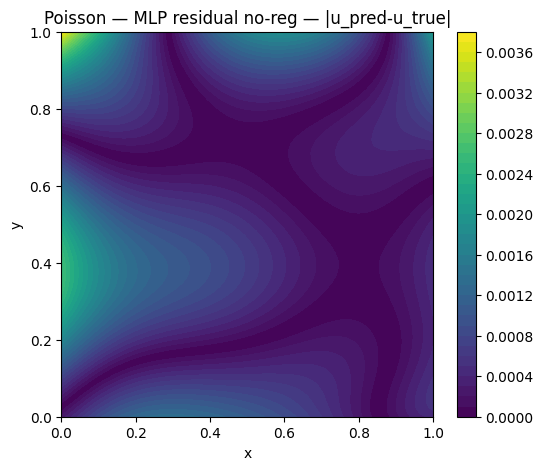


=== Poisson — MLP residual no-reg — grid metrics ===
       mse: 5.895879e-07
      rmse: 7.678463e-04
        l2: 6.910616e-02
    rel_l2: 9.662641e-04
      linf: 3.788769e-03


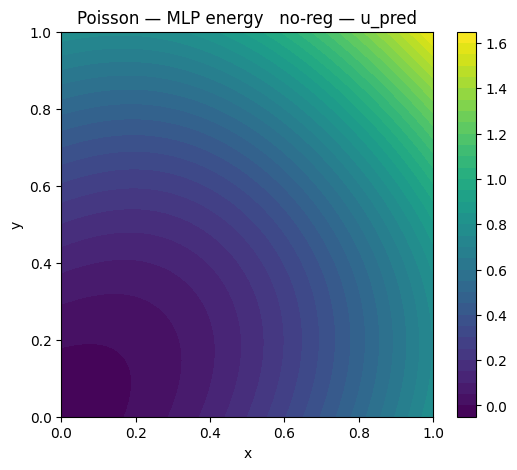

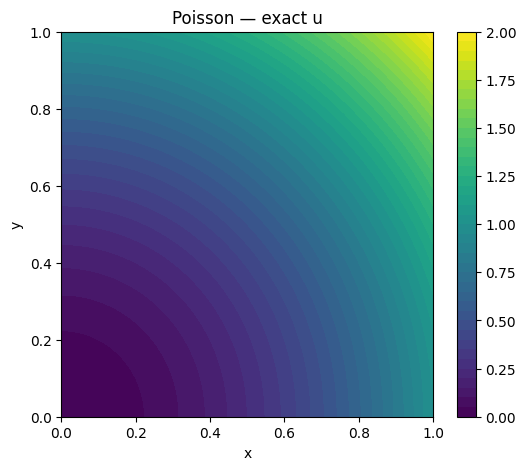

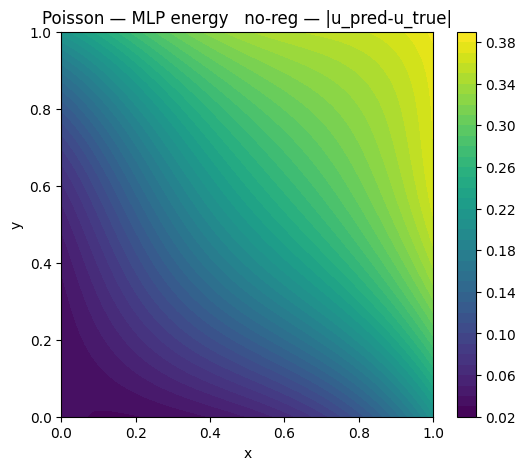


=== Poisson — MLP energy   no-reg — grid metrics ===
       mse: 5.111324e-02
      rmse: 2.260824e-01
        l2: 2.034741e+01
    rel_l2: 2.845039e-01
      linf: 3.830854e-01


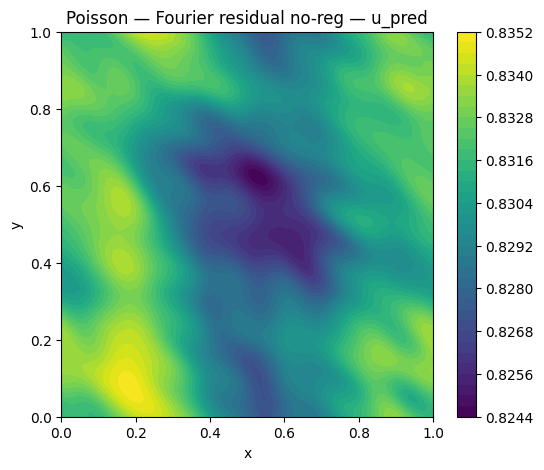

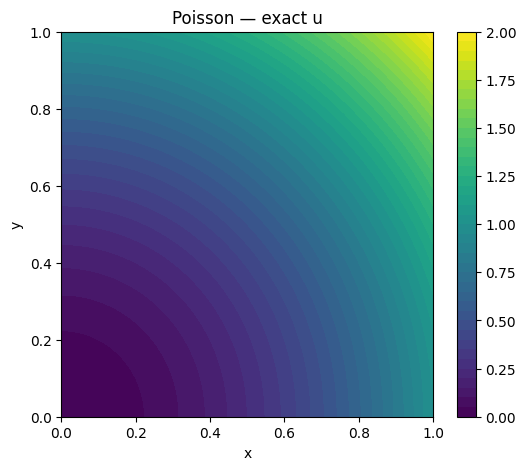

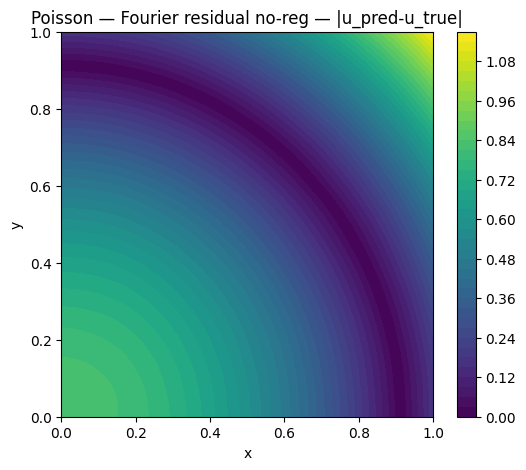


=== Poisson — Fourier residual no-reg — grid metrics ===
       mse: 2.076286e-01
      rmse: 4.556628e-01
        l2: 4.100965e+01
    rel_l2: 5.734099e-01
      linf: 1.168410e+00


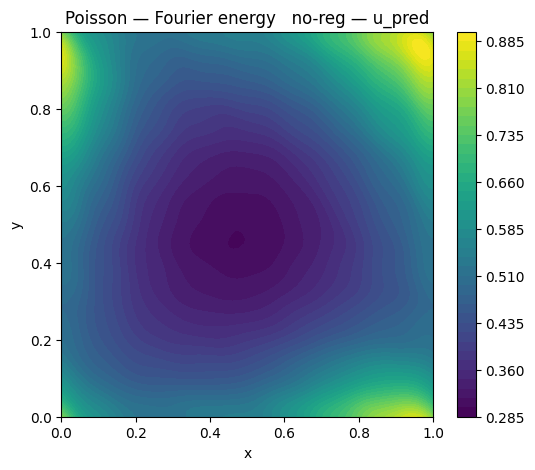

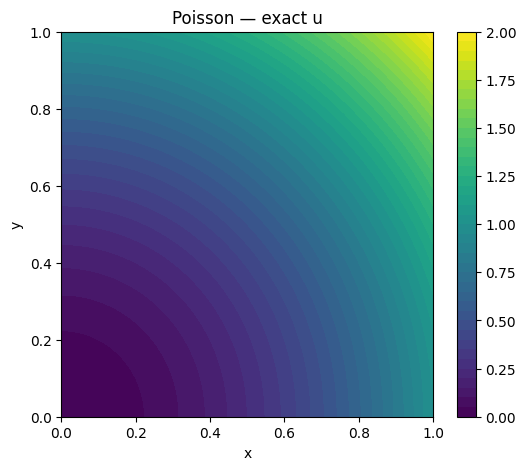

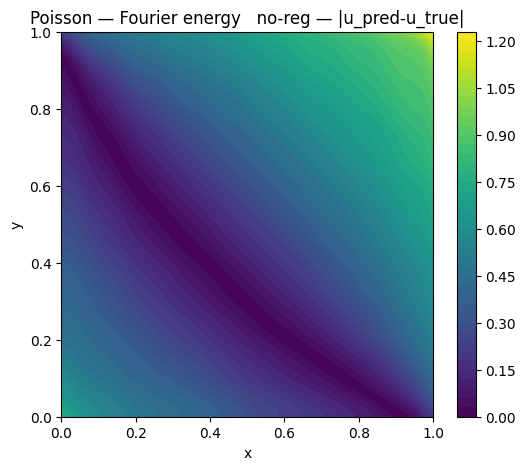


=== Poisson — Fourier energy   no-reg — grid metrics ===
       mse: 1.819221e-01
      rmse: 4.265233e-01
        l2: 3.838710e+01
    rel_l2: 5.367404e-01
      linf: 1.221520e+00


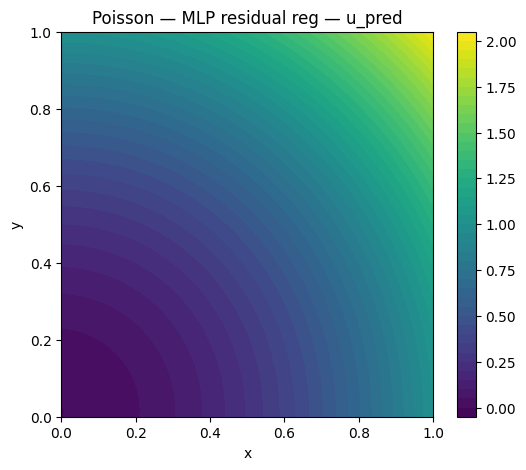

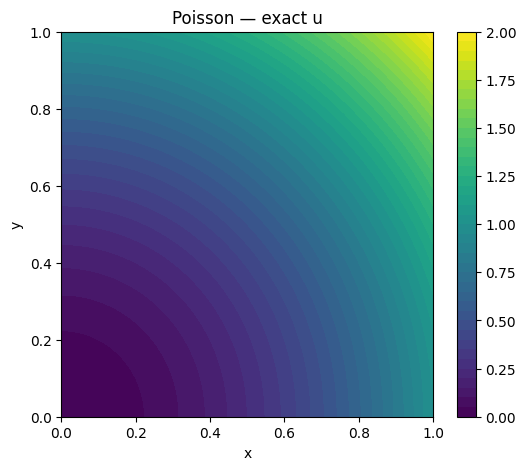

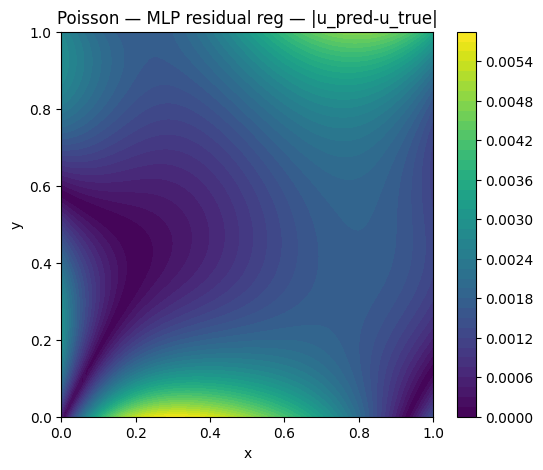


=== Poisson — MLP residual reg — grid metrics ===
       mse: 4.034382e-06
      rmse: 2.008577e-03
        l2: 1.807719e-01
    rel_l2: 2.527610e-03
      linf: 5.718812e-03


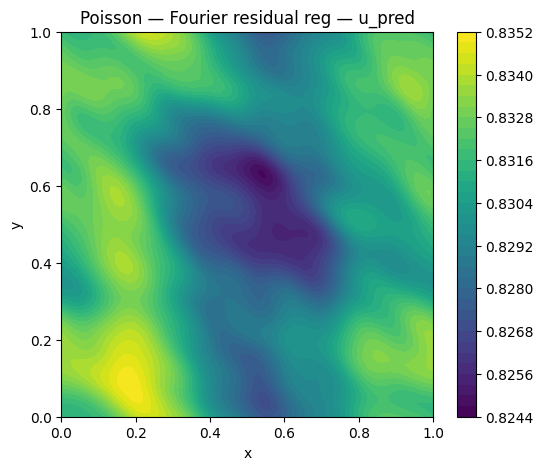

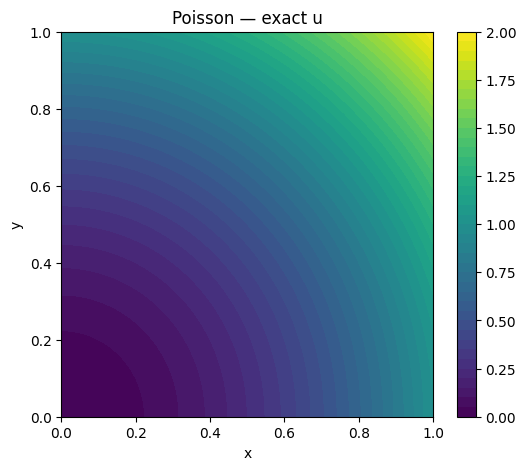

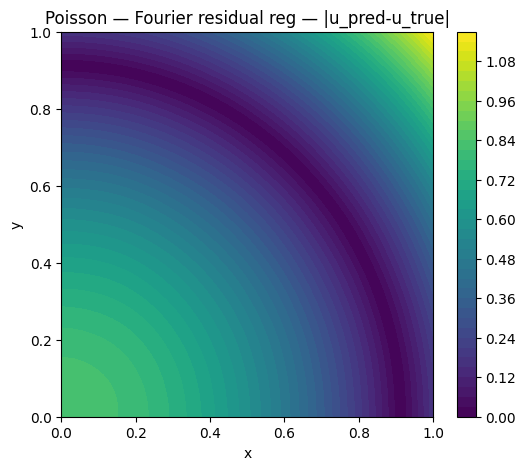


=== Poisson — Fourier residual reg — grid metrics ===
       mse: 2.076291e-01
      rmse: 4.556634e-01
        l2: 4.100970e+01
    rel_l2: 5.734105e-01
      linf: 1.168380e+00


In [9]:
for r in poisson_results:
    xs = r["xs"]
    u_pred = r["u_pred_grid"]
    u_true = r["u_true_grid"]

    plot_contour(xs, u_pred, title=f"Poisson — {r['name']} — u_pred")
    plot_contour(xs, u_true, title=f"Poisson — exact u")
    plot_error(xs, u_pred, u_true, title=f"Poisson — {r['name']} — |u_pred-u_true|")
    print_metrics(u_pred, u_true, title=f"Poisson — {r['name']} — grid metrics")


# Part B — Fisher–KPP / Logistic stationary equation (tutor dataset)

We load the dataset generated externally (finite differences + Newton).

Important:
- The dataset coordinates may be in [-0.5, 0.5) and are normalized to [0,1]^2 by the loader.
- The underlying numerical solver was periodic (torus).
  Dirichlet BCs may not be physically consistent, so we typically:
  - rely on PDE residual + data term,
  - optionally add regularization.


In [10]:
data_path = str(ROOT / "data" / "logistic_mu0.100_sx50_sy50_coef2.667.pt")

ds, info = load_torch_dataset(data_path, normalize_to_unit=True)
ds = type(ds)(x=ds.x.to(device=device, dtype=dtype), u=ds.u.to(device=device, dtype=dtype))

train_ds, val_ds = train_val_split(ds, val_ratio=0.2, shuffle=True, seed=0)

print("=== Dataset info ===")
print("Path:", data_path)
print("Normalized:", info["normalized"])
print("Train:", train_ds.x.shape, train_ds.u.shape)
print("Val  :", val_ds.x.shape, val_ds.u.shape)
print("x range:", train_ds.x.min().item(), train_ds.x.max().item())
print("u range:", train_ds.u.min().item(), train_ds.u.max().item())


=== Dataset info ===
Path: /workspaces/EA_Physics-Informed_Learning_for_Reaction_Diffusion_Equations/data/logistic_mu0.100_sx50_sy50_coef2.667.pt
Normalized: True
Train: torch.Size([2000, 2]) torch.Size([2000, 1])
Val  : torch.Size([500, 2]) torch.Size([500, 1])
x range: 0.0 1.0
u range: 0.4673982262611389 0.9119012355804443


## Fisher–KPP stationary PDE

We set (example) parameters:
- D (diffusion)
- r (reaction rate)

We train by mixing:
- PDE term (residual or energy)
- data term (fit u(x) on training set)
- optional regularization

We evaluate on:
- validation set (same grid points, supervised)
- and optionally on a dense [0,1]^2 grid for visualization.


In [11]:
eq_fisher = FisherKPPStationaryEquation(D=1.0, r=1.0)

# Collocation points (domain [0,1]^2 after normalization)
n_in, n_b = 8000, 0
x_in = sample_uniform_interior(n_in, 2, device=device, dtype=dtype)

# No BC for torus dataset by default
x_b = None
u_b = None


## Fisher experiments

We compare:
- MLP vs Fourier
- residual vs energy
- with/without regularization
- with/without data fitting term

In practice, the tutor dataset already represents a numerical solution, so the **data term is essential** to compare model expressivity.


In [13]:
fisher_results = []

configs_fisher = [
    # name, model_fn, use_energy, w_data, w_reg
    ("MLP residual + data",           make_mlp,     False, 1.0,  0.0),
    ("MLP residual + data + reg",     make_mlp,     False, 1.0,  1e-6),
    ("MLP energy   + data",           make_mlp,     True,  1.0,  0.0),
    ("Fourier residual + data",       make_fourier, False, 1.0,  0.0),
    ("Fourier residual + data + reg", make_fourier, False, 1.0,  1e-6),
    ("Fourier energy   + data",       make_fourier, True,  1.0,  0.0),
    ("MLP residual PDE-only",         make_mlp,     False, 0.0,  0.0),
    ("Fourier residual PDE-only",     make_fourier, False, 0.0,  0.0),
]

w_pde = 1.0
w_bc = 0.0
lr = 1e-3
steps = 2500
print_every = 500
grid_n = 90

for name, model_fn, use_energy, w_data, w_reg in configs_fisher:
    model = model_fn()

    print_run_config(
        name=name,
        model=model,
        equation_name="Fisher–KPP (stationary) / Logistic dataset",
        use_energy=use_energy,
        w_pde=w_pde,
        w_bc=w_bc,
        w_data=w_data,
        w_reg=w_reg,
        lr=lr,
        steps=steps,
        n_interior=x_in.shape[0],
        n_boundary=0 if x_b is None else x_b.shape[0],
        grid_n=grid_n,
        domain="[0,1]^2 (normalized)",
    )

    res = run_experiment(
        name=name,
        equation=eq_fisher,
        model=model,
        x_interior=x_in,
        x_boundary=x_b,
        u_boundary=u_b,
        x_data=train_ds.x,
        u_data=train_ds.u,
        use_energy=use_energy,
        w_pde=w_pde,
        w_bc=w_bc,
        w_data=w_data,
        w_reg=w_reg,
        lr=lr,
        steps=steps,
        print_every=print_every,
        grid_n=grid_n,
        grid_low=0.0,
        grid_high=1.0,
        u_true_fn=None,
    )
    fisher_results.append(res)

print("Done. Number of runs:", len(fisher_results))



RUN: MLP residual + data
--------------------------------------------------------------------------------
Equation       : Fisher–KPP (stationary) / Logistic dataset
Domain         : [0,1]^2 (normalized)
Model class    : MLPModel
# parameters   : 12,737
Objective      : residual (PINN)
Weights        : w_pde=1.0, w_bc=0.0, w_data=1.0, w_reg=0.0
Optimizer      : Adam(lr=0.001)
Steps          : 2500
Collocation    : interior=8000, boundary=0
Eval grid      : 90x90
[step     1] total=2.616435e-01 pde=1.904744e-03 bc=0.000000e+00 data=2.597387e-01 reg=0.000000e+00
[step   500] total=1.188684e-02 pde=2.171571e-04 bc=0.000000e+00 data=1.166968e-02 reg=0.000000e+00
[step  1000] total=1.177012e-02 pde=7.464509e-05 bc=0.000000e+00 data=1.169547e-02 reg=0.000000e+00
[step  1500] total=1.215565e-02 pde=9.965080e-05 bc=0.000000e+00 data=1.205600e-02 reg=0.000000e+00
[step  2000] total=1.172780e-02 pde=1.438136e-05 bc=0.000000e+00 data=1.171342e-02 reg=0.000000e+00
[step  2500] total=1.172591e-02 

## Fisher: loss curves

We plot losses for each configuration.
Pay attention to:
- stability of training
- how data term dominates vs PDE term
- effect of regularization (smoother training, sometimes better generalization)


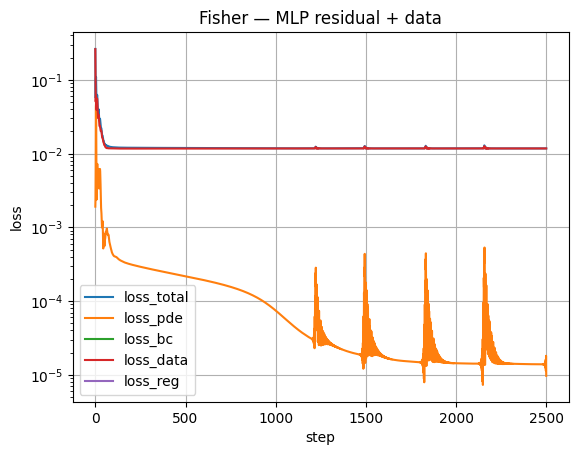

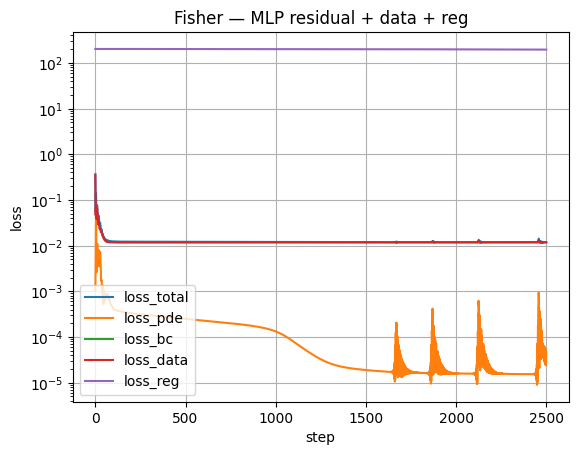

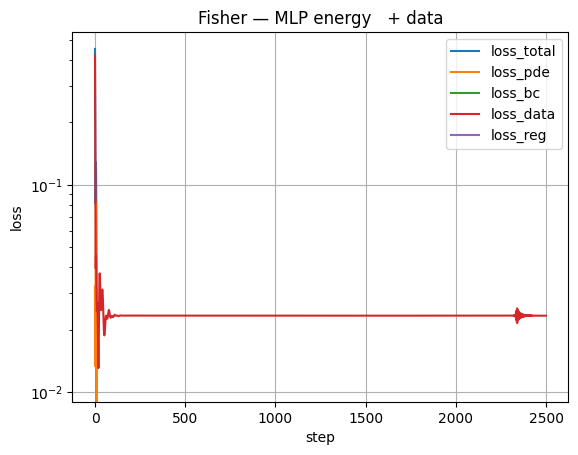

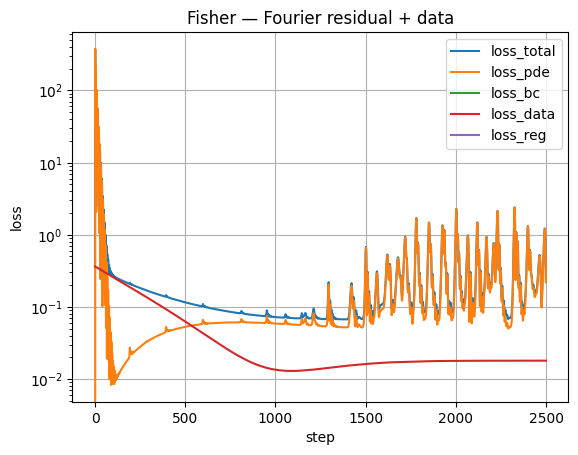

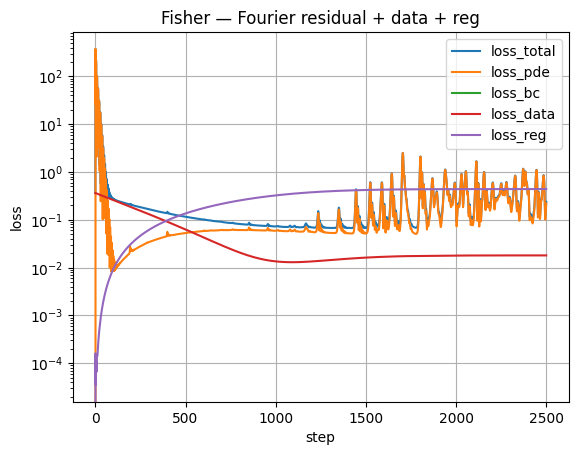

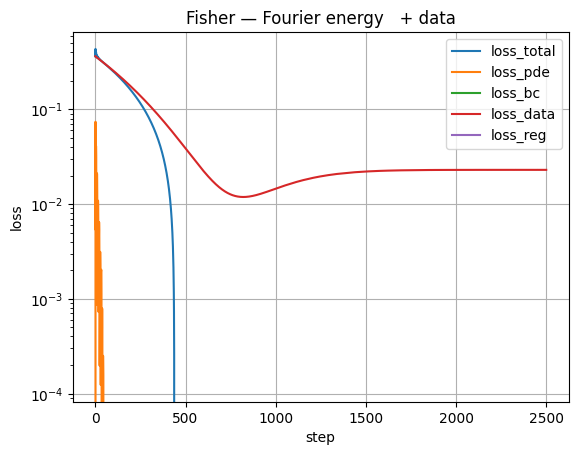

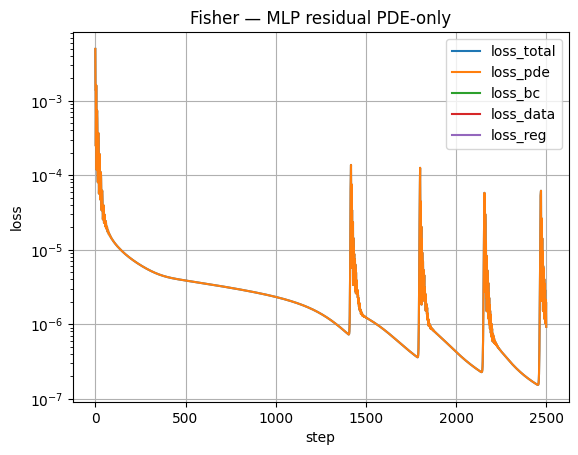

/tmp/ipykernel_52875/3775088667.py:18: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


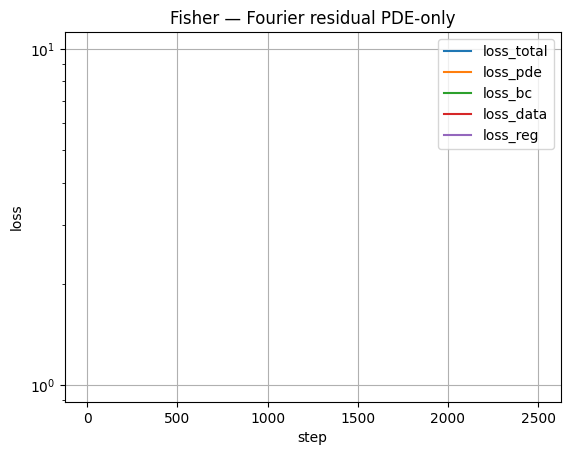

In [14]:
for r in fisher_results:
    plot_history(r["history"], title=f"Fisher — {r['name']}")


## Fisher: visualize solutions

Since we do not have an analytic solution here, we compare:
- u_pred on a dense grid
- u_true interpolated is not available (dataset is sparse grid), so we:
  - evaluate metrics on the validation set
  - and visualize u_pred on [0,1]^2

(Optionally, you can reshape the original 50x50 dataset and plot it as reference.)


In [15]:
print("=== Fisher validation metrics (on val set) ===")

for r in fisher_results:
    model = r.get("model", None)  # might not be stored; so we recompute by reusing r["u_pred_grid"] only for viz
    # We instead compute val metrics by re-evaluating:
    # NOTE: We didn't store model in r. For metrics, easiest is re-run evaluate directly here if you store it.
    # Minimal workaround: do metrics inside the run, or store model in result dict.
    pass



=== Fisher validation metrics (on val set) ===


In [16]:
for r in fisher_results:
    model = r["model"]
    model.eval()
    with torch.no_grad():
        u_val_pred = model(val_ds.x)
    print_metrics(u_val_pred, val_ds.u, title=f"Fisher — {r['name']} — val metrics")

    xs = r["xs"]
    u_pred_grid = r["u_pred_grid"]
    plot_contour(xs, u_pred_grid, title=f"Fisher — {r['name']} — u_pred (grid)")


KeyError: 'model'

## Optional: visualize the raw tutor dataset (as a surface)

If your dataset comes from a regular 50x50 grid, you can reshape it and plot it
(after normalization of x, if needed).
This helps compare visually u_pred vs u_data.


In [ ]:
# Attempt to reshape if dataset is a full grid
N = ds.x.shape[0]
side = int(N ** 0.5)

if side * side == N:
    # Sort by x then y to reshape consistently
    xy = ds.x.detach().cpu()
    u = ds.u.detach().cpu()

    idx = torch.argsort(xy[:, 0] * 10000 + xy[:, 1])
    xy_s = xy[idx]
    u_s = u[idx]

    # Build a structured grid
    xs_unique = torch.unique(xy_s[:, 0]).sort().values
    ys_unique = torch.unique(xy_s[:, 1]).sort().values

    if xs_unique.numel() * ys_unique.numel() == N:
        U = u_s.reshape(xs_unique.numel(), ys_unique.numel())
        X, Y = torch.meshgrid(xs_unique, ys_unique, indexing="ij")
        plt.figure(figsize=(6,5))
        plt.contourf(X.numpy(), Y.numpy(), U.numpy(), levels=40)
        plt.colorbar()
        plt.title("Tutor dataset u(x,y) (reshaped)")
        plt.show()
    else:
        print("Dataset is not a perfect structured grid after sorting.")
else:
    print("Dataset size is not a perfect square; cannot reshape to 2D grid.")


# Part C — Summary and comparison

We summarize key metrics:
- Poisson: grid metrics vs analytic truth
- Fisher: validation metrics vs dataset reference
We highlight best runs per PDE and per method.


In [ ]:
print("=== Poisson summary (grid metrics) ===")
for r in poisson_results:
    m = r.get("metrics_grid", None)
    if m is None:
        continue
    print(f"{r['name']:<28s}  mse={m['mse']:.3e}  rel_l2={m['rel_l2']:.3e}  linf={m['linf']:.3e}")


In [ ]:
print("=== Fisher summary (val metrics) ===")
fisher_summary = []
for r in fisher_results:
    model = r.get("model", None)
    if model is None:
        continue
    with torch.no_grad():
        u_val_pred = model(val_ds.x)
    m = summarize_errors(u_val_pred, val_ds.u)
    fisher_summary.append((r["name"], m))
    print(f"{r['name']:<30s}  mse={m['mse']:.3e}  rel_l2={m['rel_l2']:.3e}  linf={m['linf']:.3e}")


## Next steps / Improvements

- Add explicit periodicity constraints for the torus dataset:
  - enforce u(x=0,y) ≈ u(x=1,y) and same for y
  - enforce matching gradients (optional)
- Add automated logging to disk:
  - save history + config + final metrics in a results/ folder
- Add L-BFGS as optional optimizer for PINNs
- Add a consistent experiment registry (JSON configs)
